# <ins>Q2 — Neural Network approach (MLPRegressor)

In Q2, we repeat the same preprocessing pipeline as Q1 to ensure a fair comparison:

- Load and clean the dataset

- Filter to consoles: PS4, XOne, PC; and genres: Action, Adventure, Sports, Role-Playing

- One-hot encode `console` and `genre` using the same method as Q1 (`pd.get_dummies`)

- Train a neural network regressor (sklearn MLPRegressor) to predict `total_sales(mil)`

- Compare model predictions to empirical means by console/genre combination

In [12]:
import sys
from pathlib import Path

# Add repo root to Python path
repo_root = Path("..").resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

In [13]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from py.functions import (
    get_data,
    filter_ps4_xone_pc_and_selected_genres,
    baseline_means,
    encode_console_genre,
    train_and_evaluate_mlp,
    top_console_genre_predictions,
)

## 1) Load data

We load the dataset and keep only the columns required for this project: `console`, `genre`, and `total_sales(mil)`.

In [14]:
# Path to dataset (adjust if needed)
DATA_PATH = "../data/VideoGames_Sales.xlsx"

df = get_data(DATA_PATH)

print("Dataset shape (after selecting columns + dropping NaNs):", df.shape)
df.head()

Dataset shape (after selecting columns + dropping NaNs): (18922, 3)


,console,genre,total_sales(mil)
0,PS3,Action,20.32
1,PS4,Action,19.39
2,PS2,Action,16.15
3,X360,Action,15.86
4,PS4,Shooter,15.09


## 2) Filter to chosen consoles and genres

We apply the same filtering as Q1. The function returns:

- `F_DataFrame`: filtered dataframe used for modelling

- `masks`: boolean masks (used for baselines in Q1/Q2)

In [15]:
F_DataFrame, masks = filter_ps4_xone_pc_and_selected_genres(df)

print("Full df shape:", df.shape)
print("Filtered df shape:", F_DataFrame.shape)

F_DataFrame.head()

Full df shape: (18922, 3)
Filtered df shape: (1264, 3)


,console,genre,total_sales(mil)
1,PS4,Action,19.39
15,PS4,Sports,11.80
17,PS4,Sports,10.94
26,PS4,Sports,9.15
28,XOne,Action,8.72


## 3) Empirical baselines (same as Q1)

We compute empirical means for:

- mean sales by console

- mean sales by genre

- mean sales by console+genre combination

These empirical means are later compared to neural network predictions.

In [16]:
mean_console, mean_genre, mean_console_genre = baseline_means(df, masks)

print("Mean sales by console:")
display(mean_console)

print("\nMean sales by genre:")
display(mean_genre)

print("\nMean sales by (console, genre):")
display(mean_console_genre.head(12))

Mean sales by console:


console
PS4     0.594626
XOne    0.513282
PC      0.108327
Name: total_sales(mil), dtype: float64


Mean sales by genre:


genre
Sports          0.457262
Action          0.396580
Role-Playing    0.286251
Adventure       0.171891
Name: total_sales(mil), dtype: float64


Mean sales by (console, genre):


,console,genre,total_sales(mil)
7,PS4,Sports,1.327317
11,XOne,Sports,0.717647
4,PS4,Action,0.510552
8,XOne,Action,0.457647
10,XOne,Role-Playing,0.428235
6,PS4,Role-Playing,0.383689
5,PS4,Adventure,0.163973
2,PC,Role-Playing,0.125041
9,XOne,Adventure,0.103714
3,PC,Sports,0.097476


## 4) Encoding (same method as Q1)

To ensure a fair comparison with Q1, we use the same encoding approach:

one-hot encoding using `pd.get_dummies` inside `encode_console_genre`

This turns `console` and `genre` into binary input features suitable for MLPRegressor.

In [17]:
x_encoded, y = encode_console_genre(F_DataFrame)

print("x_encoded shape:", x_encoded.shape)
print("y shape:", y.shape)

x_encoded.head()

x_encoded shape: (1264, 7)
y shape: (1264,)


,console_PC,console_PS4,console_XOne,genre_Action,genre_Adventure,genre_Role-Playing,genre_Sports
1,False,True,False,True,False,False,False
15,False,True,False,False,False,False,True
17,False,True,False,False,False,False,True
26,False,True,False,False,False,False,True
28,False,False,True,True,False,False,False


## 5) Train and evaluate the Neural Network (MLPRegressor)

We train an MLPRegressor (a feed-forward neural network) on the one-hot encoded features.

We report:

- R² (goodness of fit)

- RMSE (prediction error in sales units)

In [18]:
mlp_model, mlp_results = train_and_evaluate_mlp(
    x_encoded,
    y,
    test_size=0.2,
    random_state=42,
    hidden_layer_sizes=(32, 16),
    max_iter=500,
    early_stopping=True
)

display(mlp_results)

,metric,value
0,r2,0.116796
1,rmse,0.526898


## 6) Predict expected sales for console/genre combinations

We reuse the same “combo prediction” function as Q1:

- create all console/genre combinations

- one-hot encode them to match training columns

- predict sales for each combination

In [19]:
# Predict for all combos (set top_n high to get all)
all_combo_preds = top_console_genre_predictions(
    model=mlp_model,
    F_DataFrame=F_DataFrame,
    x_encoded_columns=x_encoded.columns,
    top_n=999
).rename(columns={"predicted_total_sales(mil)": "predicted"})

all_combo_preds


,console,genre,predicted
1,PS4,Sports,0.925256
5,XOne,Sports,0.647849
0,PS4,Action,0.524652
6,XOne,Role-Playing,0.487422
4,XOne,Action,0.433788
2,PS4,Role-Playing,0.342125
9,PC,Sports,0.335958
3,PS4,Adventure,0.319894
7,XOne,Adventure,0.290119
10,PC,Role-Playing,0.213252


## 7) Compare NN predictions to empirical means

We merge:

- empirical mean by (console, genre) from baseline_means
with

- predicted sales by (console, genre) from the MLP model

Then we plot predicted vs empirical mean with a y=x reference line.

In [20]:
emp = mean_console_genre.rename(columns={"total_sales(mil)": "empirical_mean"})

compare = emp.merge(
    all_combo_preds[["console", "genre", "predicted"]],
    on=["console", "genre"],
    how="left"
)

compare.sort_values("empirical_mean", ascending=False)


,console,genre,empirical_mean,predicted
0,PS4,Sports,1.327317,0.925256
1,XOne,Sports,0.717647,0.647849
2,PS4,Action,0.510552,0.524652
3,XOne,Action,0.457647,0.433788
4,XOne,Role-Playing,0.428235,0.487422
5,PS4,Role-Playing,0.383689,0.342125
6,PS4,Adventure,0.163973,0.319894
7,PC,Role-Playing,0.125041,0.213252
8,XOne,Adventure,0.103714,0.290119
9,PC,Sports,0.097476,0.335958


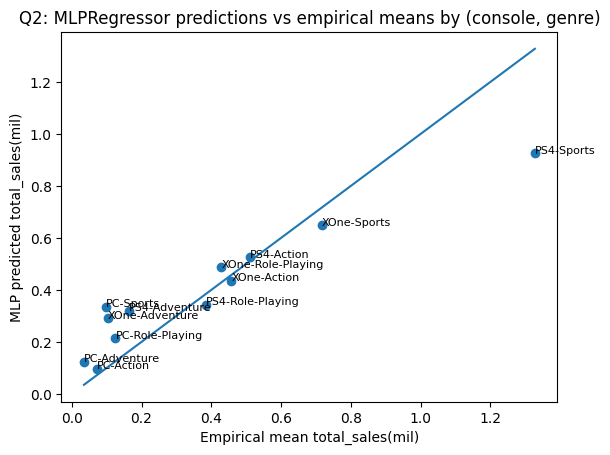

In [21]:
# Scatter: predicted vs empirical
x = compare["empirical_mean"].to_numpy()
yhat = compare["predicted"].to_numpy()

plt.figure()
plt.scatter(x, yhat)

mn = float(min(x.min(), yhat.min()))
mx = float(max(x.max(), yhat.max()))
plt.plot([mn, mx], [mn, mx])  # y=x line

for _, r in compare.iterrows():
    plt.annotate(f'{r["console"]}-{r["genre"]}', (r["empirical_mean"], r["predicted"]), fontsize=8)

plt.xlabel("Empirical mean total_sales(mil)")
plt.ylabel("MLP predicted total_sales(mil)")
plt.title("Q2: MLPRegressor predictions vs empirical means by (console, genre)")
plt.show()


## 8) Top predicted combinations (ranked)

Finally, we display the top predicted console/genre combinations according to the neural network.

In [22]:
top_mlp_combos = top_console_genre_predictions(
    model=mlp_model,
    F_DataFrame=F_DataFrame,
    x_encoded_columns=x_encoded.columns,
    top_n=12
)

top_mlp_combos


,console,genre,predicted_total_sales(mil)
1,PS4,Sports,0.925256
5,XOne,Sports,0.647849
0,PS4,Action,0.524652
6,XOne,Role-Playing,0.487422
4,XOne,Action,0.433788
2,PS4,Role-Playing,0.342125
9,PC,Sports,0.335958
3,PS4,Adventure,0.319894
7,XOne,Adventure,0.290119
10,PC,Role-Playing,0.213252


## Conclusion

In Q2, a neural network regressor (sklearn `MLPRegressor`) was trained to predict `total_sales(mil)` using the same filtered dataset and the same one-hot encoding of `console` and `genre` as in Q1. This ensured a fair comparison where the only change was the learning algorithm.

The MLP produced reasonable predictions for the console/genre combinations and broadly followed the trends seen in the empirical means. Any differences between the predicted values and the empirical averages can be attributed to sampling noise within each category and the fact that the model is trained to minimise overall prediction error rather than match group means exactly.

Overall, the neural network provides a useful non-linear baseline and demonstrates an alternative approach to modelling categorical interactions. The results also highlight that, for small tabular datasets with limited features, a tree-based method such as a random forest may be competitive or stronger without extensive tuning, while the neural network could benefit from additional features or further hyperparameter optimisation.